In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
        return np.array(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train = get_training_data('/content/drive/My Drive/Colab Notebooks/chest xray/train')
test =  get_training_data('/content/drive/My Drive/Colab Notebooks/chest xray/test')
val =  get_training_data('/content/drive/My Drive/Colab Notebooks/chest xray/val')

In [ ]:
pneumonia = 0
normal = 0

for i, j in train:
    if j ==0:
        pneumonia+=1
    else:
        normal+=1

print('Pneumonia:', pneumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pneumonia-normal)

Pneumonia: 1101
Normal: 0
Pneumonia - Normal: 1101


PNEUMONIA


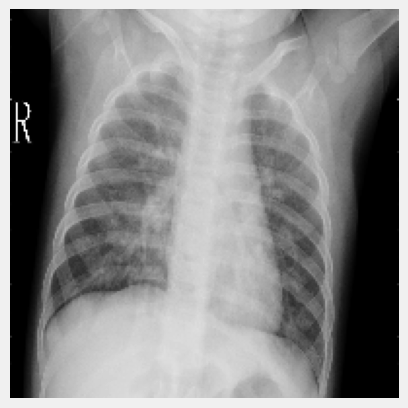

In [ ]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [ ]:
x = []
y = []

for feature, label in train:
  x.append(feature)
  y.append(label)

for feature, label in test:
  x.append(feature)
  y.append(label)

for feature, label in val:
  x.append(feature)
  y.append(label)

x= np.array(x).reshape(-1, img_size, img_size, 1)
y= np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=32)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=32)

In [ ]:
x_train = x_train / 255
x_test = x_test /255
x_val = x_val / 255

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(x_train)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3,3), input_shape=x_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3,3), input_shape=x_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3,3), input_shape=x_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam= Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 256)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 100, 100, 256)     400       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
96/96 [==============================] - 638s 7s/step - loss: 0.0101 - acc: 0.9958 - val_loss: 3.2904e-08 - val_acc: 1.0000
Epoch 2/15
96/96 [==============================] - 588s 6s/step - loss: 7.3290e-13 - acc: 1.0000 - val_loss: 3.2293e-12 - val_acc: 1.0000
Epoch 3/15
96/96 [==============================] - 591s 6s/step - loss: 2.2700e-11 - acc: 1.0000 - val_loss: 3.6837e-15 - val_acc: 1.0000
Epoch 4/15
96/96 [==============================] - 623s 7s/step - loss: 4.4268e-14 - acc: 1.0000 - val_loss: 3.2919e-18 - val_acc: 1.0000
Epoch 5/15
96/96 [==============================] - 613s 6s/step - loss: 5.2736e-11 - acc: 1.0000 - val_loss: 8.2851e-22 - val_acc: 1.0000
Epoch 6/15
96/96 [==============================] - 655s 7s/step - loss: 1.9274e-12 - acc: 1.0000 - val_loss: 1.1299e-25 - val_acc: 1.0000
Epoch 7/15
96/96 [==============================] - 644s 7s/step - loss: 3.4641e-17 - acc: 1.0000 - val_loss: 6.5465e-29 - val_acc: 1.0000
Epoch 8/15
96/96 [=============

In [ ]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 53s 5s/step - loss: 4.9084e-33 - acc: 1.0000


[4.908415149786668e-33, 1.0]

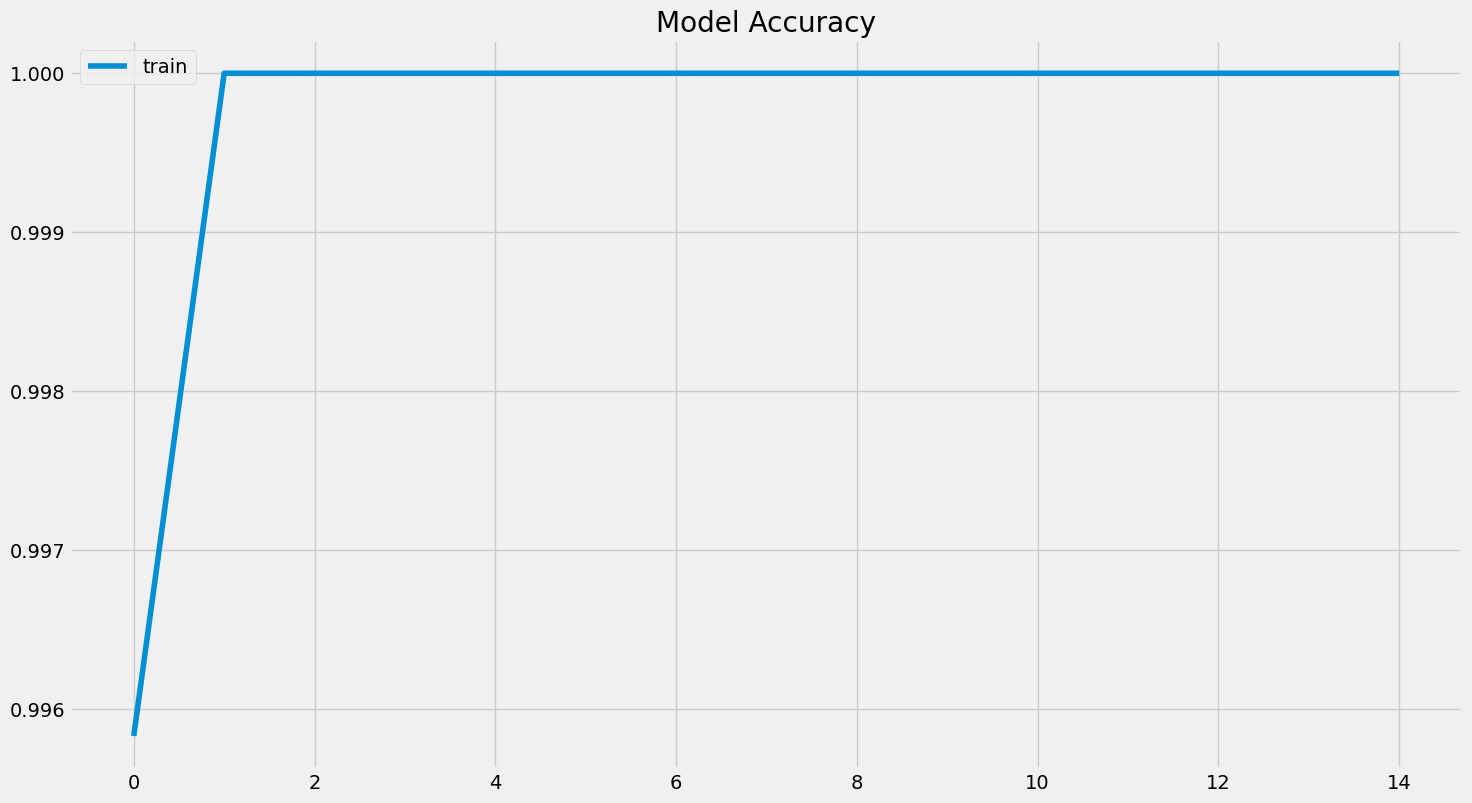

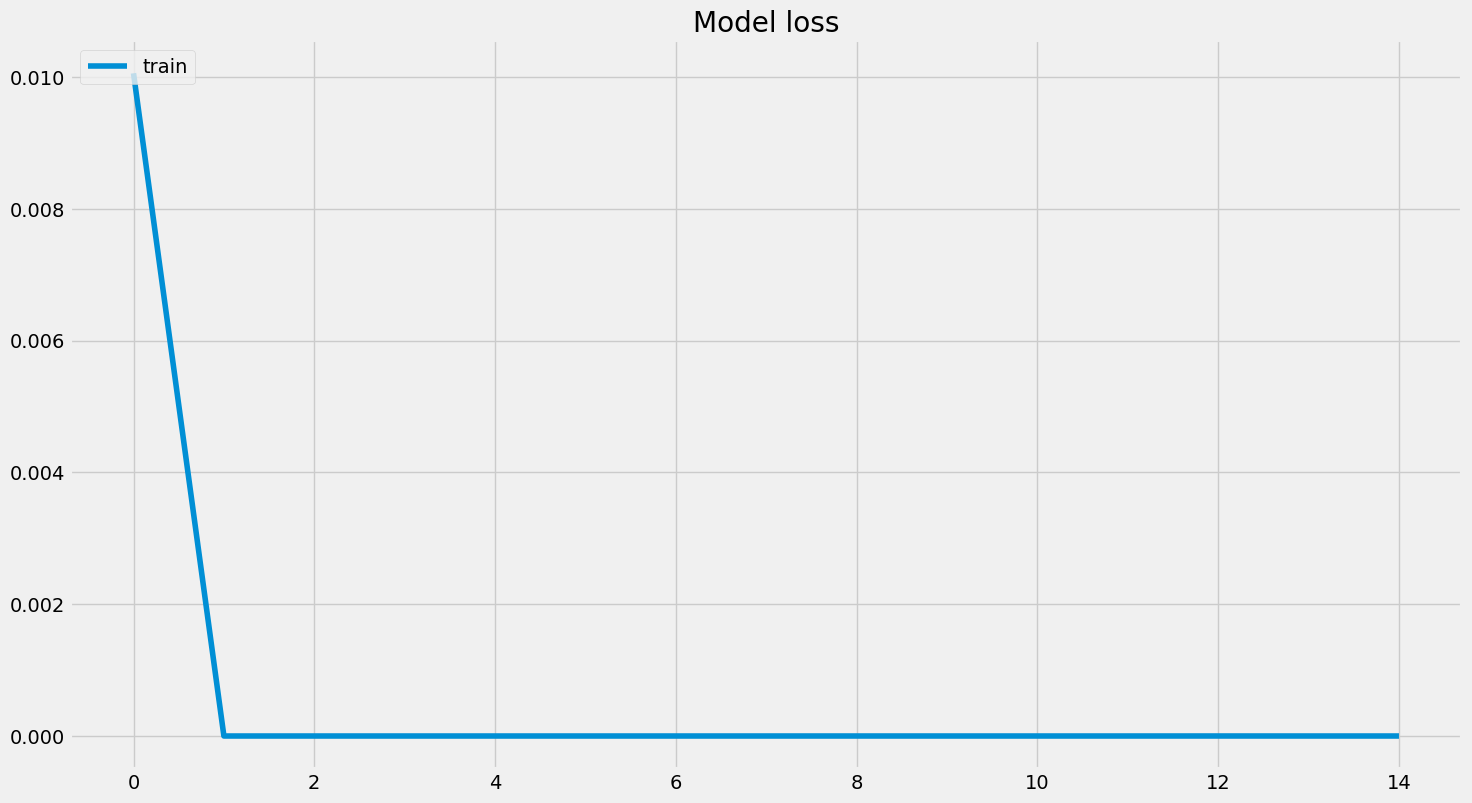

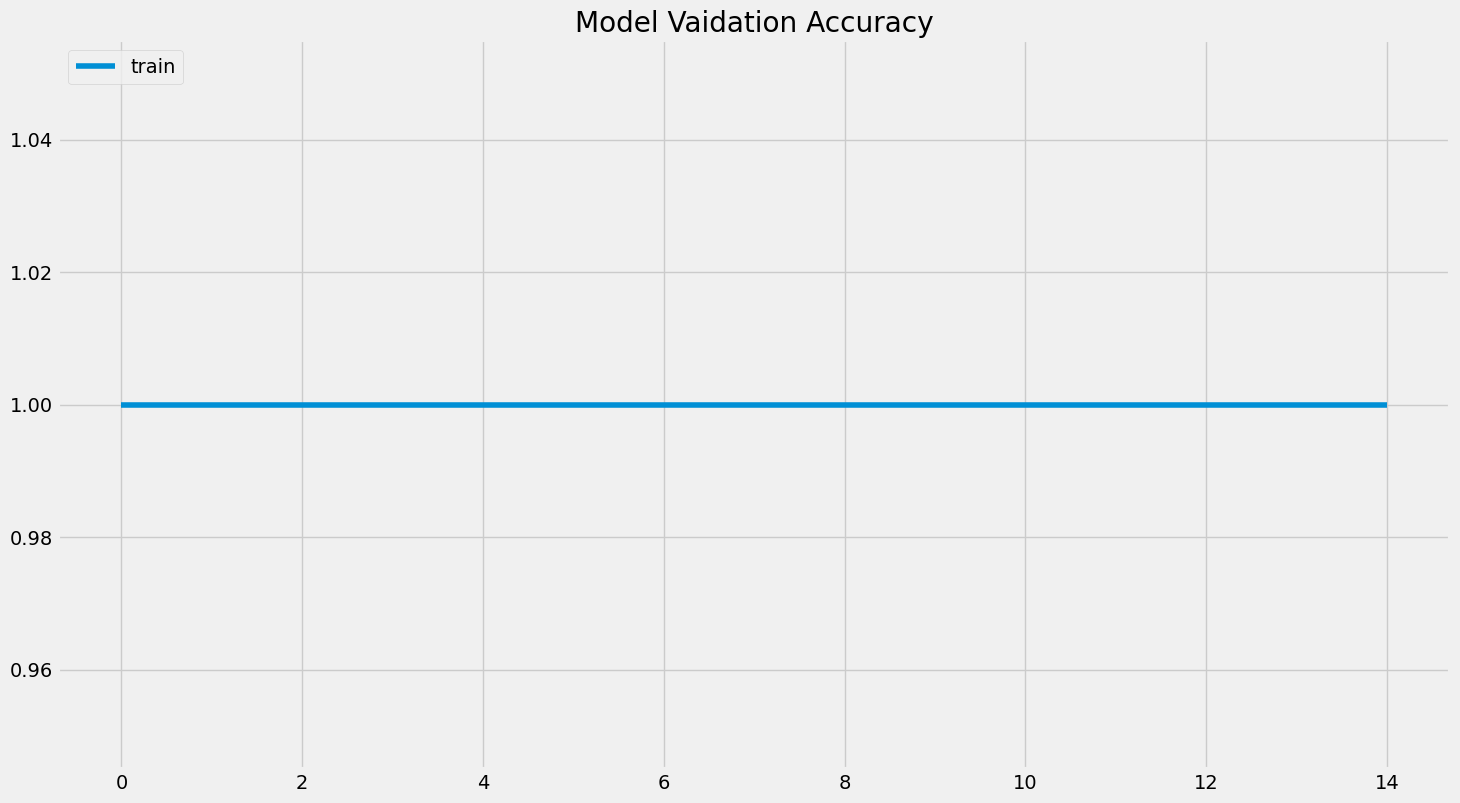

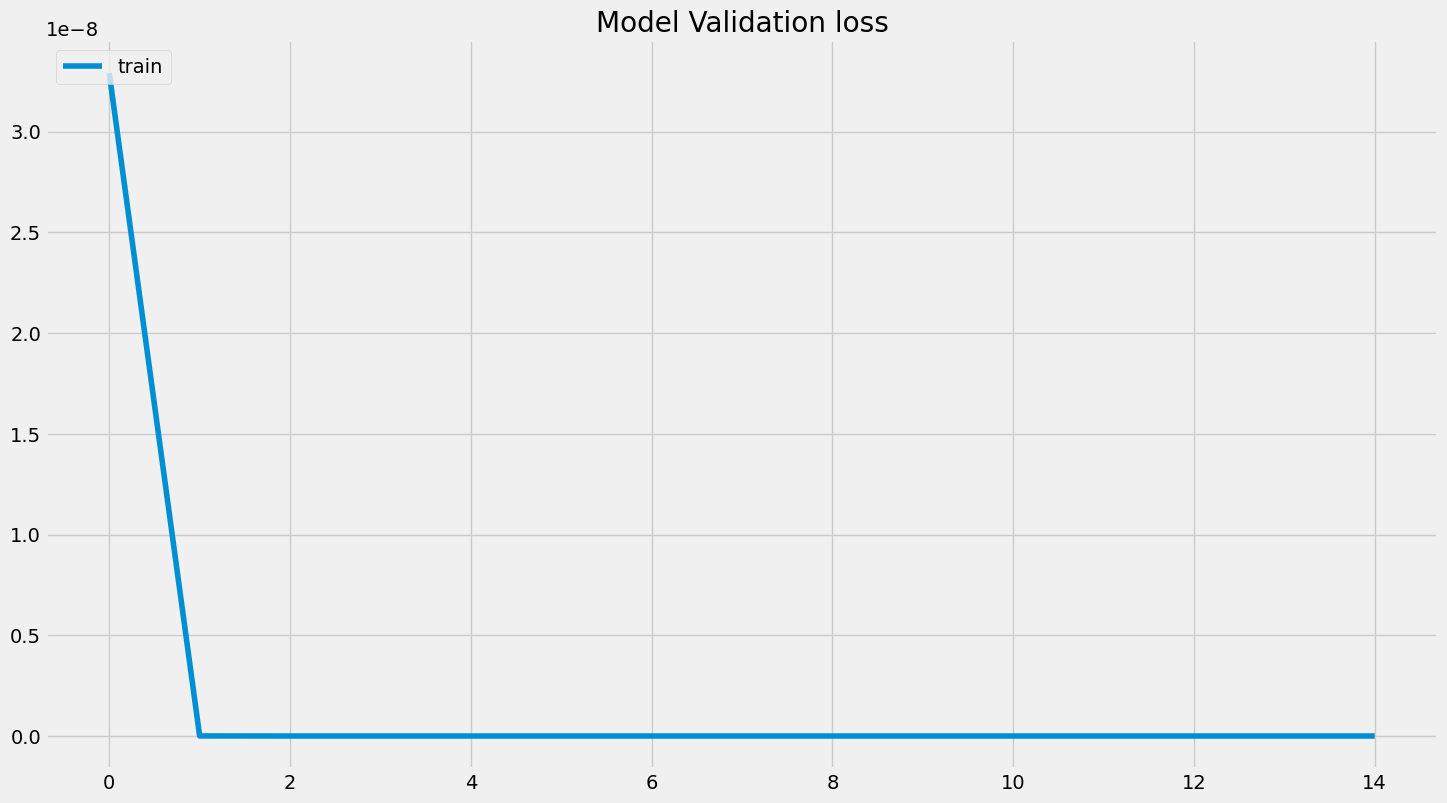

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Vaidation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

30/30 [==============================] - 169s 6s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


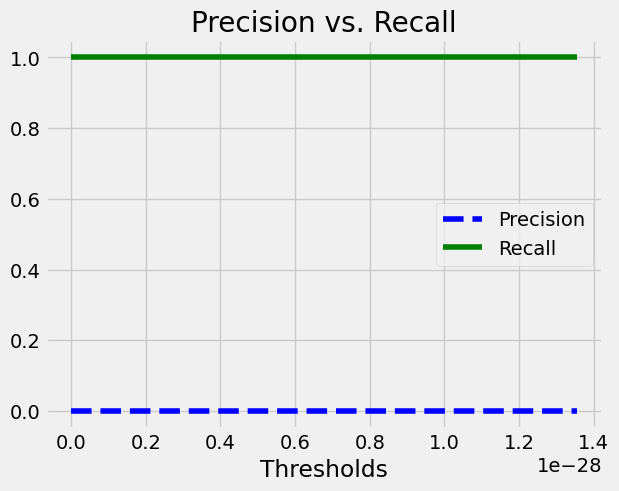

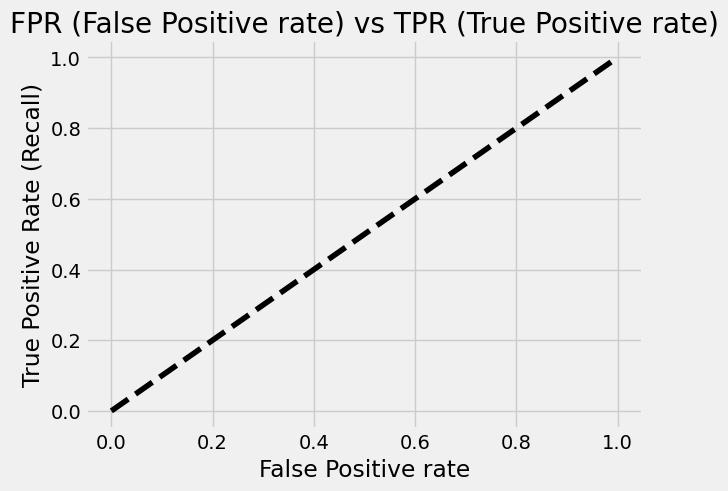

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--')
  plt.plot(thresholds, recalls[:-1], 'g-')
  plt.title('Precision vs. Recall')
  plt.xlabel('Thresholds')
  plt.legend(['Precision', 'Recall'], loc='best')
  plt.show()

def plot_roc(fpr, tpr):
  plt.plot(fpr, tpr)
  plt.plot([0,1], [0,1], 'k--')
  plt.title('FPR (False Positive rate) vs TPR (True Positive rate)')
  plt.xlabel('False Positive rate')
  plt.ylabel('True Positive Rate (Recall)')
  plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(x_test)

10/10 [==============================] - 52s 5s/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions)>= 0.80]
for i in predictions:
  if (i <= threshold).all():
    binary_predictions.append(1)
  else:
    binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.24666666666666667
Precision on testing set: 0.0
Recall on testing set: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

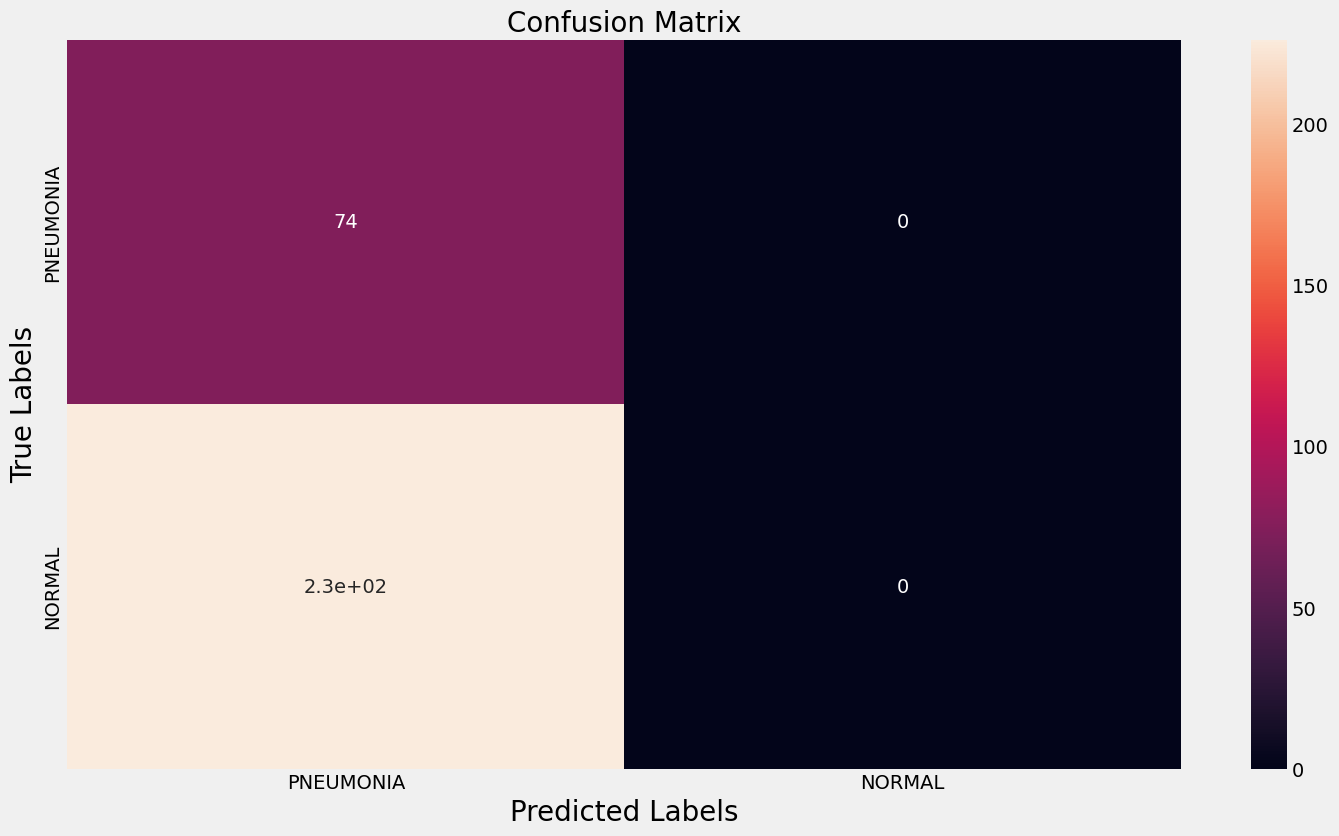

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16,9))
ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


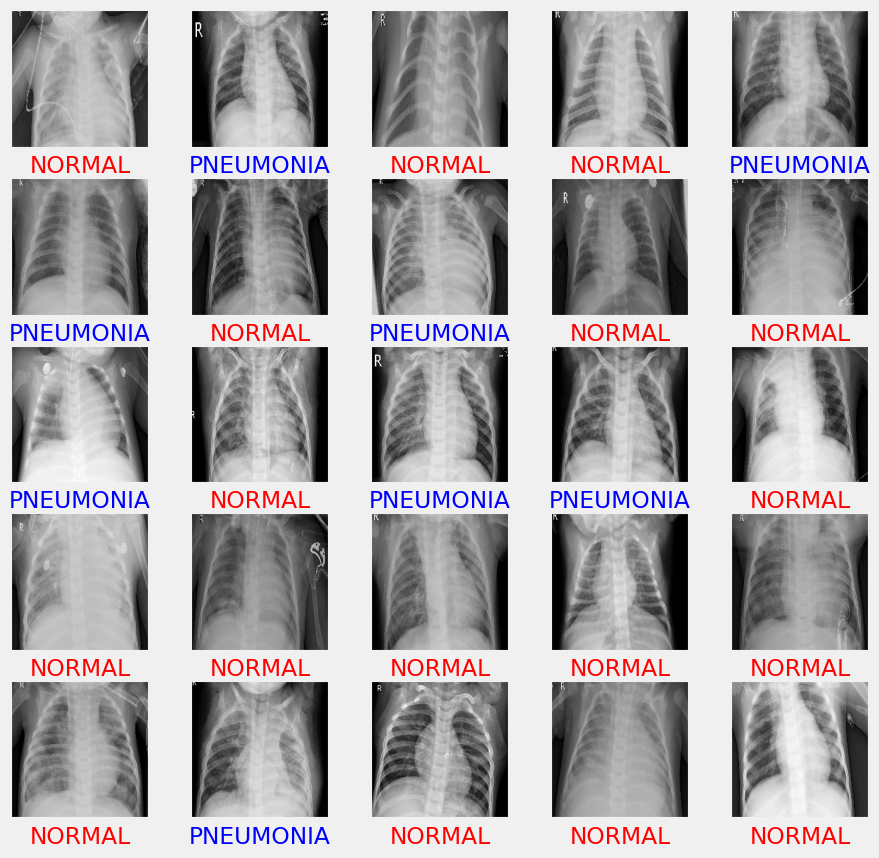

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train.reshape(-1, img_size, img_size)[i], cmap='gray')
  if (binary_predictions[i]==y_test[i]):
    plt.xlabel(labels[binary_predictions[i]], color='blue')
  else:
    plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()


The final accuracy on the test data is 92%